In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, RFE, 
    SelectFromModel, VarianceThreshold
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("🔧 FEATURE MANIPULATION AND ENGINEERING")
print("🎯 Goal: Create optimal feature set for asthma prediction")
print("=" * 70)

🔧 FEATURE MANIPULATION AND ENGINEERING
🎯 Goal: Create optimal feature set for asthma prediction


In [3]:
# =============================================================================
# 1. DATA LOADING AND PREPARATION
# =============================================================================

# Load processed data
df = pd.read_csv('../../data/processed/asthma_data_processed.csv')
print(f"📊 Loaded processed dataset: {df.shape}")

# Separate features and target
TARGET_COLUMN = 'Diagnosis'
ID_COLUMN = 'PatientID'

X = df.drop([TARGET_COLUMN, ID_COLUMN], axis=1)
y = df[TARGET_COLUMN]

print(f"📋 Initial feature set:")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]}")
print(f"   Target classes: {y.value_counts().to_dict()}")

# Create a copy for manipulation
X_original = X.copy()
print(f"\n📁 Original features: {list(X.columns)}")

📊 Loaded processed dataset: (2392, 32)
📋 Initial feature set:
   Features: 30
   Samples: 2392
   Target classes: {0: 2268, 1: 124}

📁 Original features: ['Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3', 'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3']


In [5]:
# =============================================================================
# 2. DOMAIN-SPECIFIC FEATURE ENGINEERING
# =============================================================================

print(f"\n" + "="*70)
print(f"🧬 DOMAIN-SPECIFIC FEATURE ENGINEERING")
print("="*70)

# Create working dataframe for feature engineering
df_eng = df.copy()

print(f"🏥 Creating medically meaningful features:")

# 1. RESPIRATORY HEALTH COMPOSITE SCORE
print(f"\n1️⃣  Respiratory Health Features:")

# Lung Function Ratio (FEV1/FVC - important medical indicator)
if 'LungFunctionFEV1' in df_eng.columns and 'LungFunctionFVC' in df_eng.columns:
    df_eng['LungFunctionRatio'] = df_eng['LungFunctionFEV1'] / (df_eng['LungFunctionFVC'] + 1e-6)
    print(f"   ✅ Created LungFunctionRatio (FEV1/FVC)")

# Symptom Severity Score (sum of all symptoms)
symptom_cols = ['Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 
               'NighttimeSymptoms', 'ExerciseInduced']
available_symptoms = [col for col in symptom_cols if col in df_eng.columns]

if available_symptoms:
    df_eng['SymptomSeverityScore'] = df_eng[available_symptoms].sum(axis=1)
    print(f"   ✅ Created SymptomSeverityScore (sum of {len(available_symptoms)} symptoms)")

# Respiratory Distress Index (weighted symptoms)
if len(available_symptoms) >= 4:
    weights = {'Wheezing': 1.2, 'ShortnessOfBreath': 1.5, 'ChestTightness': 1.0, 
               'Coughing': 0.8, 'NighttimeSymptoms': 1.3, 'ExerciseInduced': 1.1}
    df_eng['RespiratoryDistressIndex'] = 0
    for symptom in available_symptoms:
        if symptom in weights:
            df_eng['RespiratoryDistressIndex'] += df_eng[symptom] * weights[symptom]
    print(f"   ✅ Created RespiratoryDistressIndex (weighted symptoms)")

# 2. ALLERGY AND SENSITIVITY PROFILE
print(f"\n2️⃣  Allergy and Environmental Features:")

# Total Allergy Burden
allergy_cols = ['PetAllergy', 'HistoryOfAllergies', 'Eczema', 'HayFever']
available_allergies = [col for col in allergy_cols if col in df_eng.columns]

if available_allergies:
    df_eng['TotalAllergyBurden'] = df_eng[available_allergies].sum(axis=1)
    print(f"   ✅ Created TotalAllergyBurden (sum of {len(available_allergies)} allergies)")

# Environmental Exposure Index
env_cols = ['PollutionExposure', 'PollenExposure', 'DustExposure']
available_env = [col for col in env_cols if col in df_eng.columns]

if available_env:
    df_eng['EnvironmentalExposureIndex'] = df_eng[available_env].sum(axis=1)
    print(f"   ✅ Created EnvironmentalExposureIndex")

# Atopic Triad Score (Asthma, Eczema, Allergies - medical concept)
atopic_features = ['HistoryOfAllergies', 'Eczema', 'HayFever']
available_atopic = [col for col in atopic_features if col in df_eng.columns]

if len(available_atopic) >= 2:
    df_eng['AtopicTriadScore'] = df_eng[available_atopic].sum(axis=1)
    print(f"   ✅ Created AtopicTriadScore (atopic dermatitis triad)")

# 3. LIFESTYLE RISK FACTORS
print(f"\n3️⃣  Lifestyle Risk Factors:")

# BMI Categories (medical standard categories)
if 'BMI' in df_eng.columns:
    # Create BMI risk categories
    df_eng['BMI_Underweight'] = (df_eng['BMI'] < 18.5).astype(int)
    df_eng['BMI_Normal'] = ((df_eng['BMI'] >= 18.5) & (df_eng['BMI'] < 25)).astype(int)
    df_eng['BMI_Overweight'] = ((df_eng['BMI'] >= 25) & (df_eng['BMI'] < 30)).astype(int)
    df_eng['BMI_Obese'] = (df_eng['BMI'] >= 30).astype(int)
    print(f"   ✅ Created BMI category features")

# Health Lifestyle Score
lifestyle_cols = ['PhysicalActivity', 'DietQuality', 'SleepQuality']
available_lifestyle = [col for col in lifestyle_cols if col in df_eng.columns]

if available_lifestyle:
    # Reverse smoking (0 = good, 1 = bad) for composite score
    df_eng['HealthyLifestyleScore'] = df_eng[available_lifestyle].sum(axis=1)
    if 'Smoking' in df_eng.columns:
        df_eng['HealthyLifestyleScore'] -= df_eng['Smoking']  # Subtract smoking (bad habit)
    print(f"   ✅ Created HealthyLifestyleScore")

# 4. GENETIC/FAMILIAL RISK
print(f"\n4️⃣  Genetic and Familial Risk:")

# Family History Combined Score
family_features = ['FamilyHistoryAsthma']
available_family = [col for col in family_features if col in df_eng.columns]

if available_family:
    df_eng['FamilialRiskScore'] = df_eng[available_family].sum(axis=1)
    print(f"   ✅ Created FamilialRiskScore")

# 5. AGE-RELATED FEATURES
print(f"\n5️⃣  Age-Related Features:")

if 'Age' in df_eng.columns:
    # Age groups (pediatric, adult, elderly)
    df_eng['Age_Pediatric'] = (df_eng['Age'] < 18).astype(int)
    df_eng['Age_YoungAdult'] = ((df_eng['Age'] >= 18) & (df_eng['Age'] < 35)).astype(int)
    df_eng['Age_MiddleAge'] = ((df_eng['Age'] >= 35) & (df_eng['Age'] < 65)).astype(int)
    df_eng['Age_Elderly'] = (df_eng['Age'] >= 65).astype(int)
    
    # Age squared (non-linear relationship)
    df_eng['Age_Squared'] = df_eng['Age'] ** 2
    print(f"   ✅ Created age group and non-linear age features")


🧬 DOMAIN-SPECIFIC FEATURE ENGINEERING
🏥 Creating medically meaningful features:

1️⃣  Respiratory Health Features:
   ✅ Created LungFunctionRatio (FEV1/FVC)
   ✅ Created SymptomSeverityScore (sum of 6 symptoms)
   ✅ Created RespiratoryDistressIndex (weighted symptoms)

2️⃣  Allergy and Environmental Features:
   ✅ Created TotalAllergyBurden (sum of 4 allergies)
   ✅ Created EnvironmentalExposureIndex
   ✅ Created AtopicTriadScore (atopic dermatitis triad)

3️⃣  Lifestyle Risk Factors:
   ✅ Created BMI category features
   ✅ Created HealthyLifestyleScore

4️⃣  Genetic and Familial Risk:
   ✅ Created FamilialRiskScore

5️⃣  Age-Related Features:
   ✅ Created age group and non-linear age features


In [6]:
# =============================================================================
# 3. INTERACTION FEATURES
# =============================================================================

print(f"\n" + "="*70)
print(f"🔗 INTERACTION FEATURES")
print("="*70)

print(f"🤝 Creating medically meaningful interactions:")

# 1. Age × Risk Factors
if 'Age' in df_eng.columns:
    if 'Smoking' in df_eng.columns:
        df_eng['Age_Smoking_Interaction'] = df_eng['Age'] * df_eng['Smoking']
        print(f"   ✅ Age × Smoking interaction")
    
    if 'FamilyHistoryAsthma' in df_eng.columns:
        df_eng['Age_FamilyHistory_Interaction'] = df_eng['Age'] * df_eng['FamilyHistoryAsthma']
        print(f"   ✅ Age × Family History interaction")

# 2. Environmental × Allergy Interactions
if 'EnvironmentalExposureIndex' in df_eng.columns and 'TotalAllergyBurden' in df_eng.columns:
    df_eng['Environment_Allergy_Interaction'] = (df_eng['EnvironmentalExposureIndex'] * 
                                                df_eng['TotalAllergyBurden'])
    print(f"   ✅ Environmental Exposure × Allergy interaction")

# 3. Lifestyle × Symptoms
if 'HealthyLifestyleScore' in df_eng.columns and 'SymptomSeverityScore' in df_eng.columns:
    df_eng['Lifestyle_Symptoms_Interaction'] = (df_eng['HealthyLifestyleScore'] * 
                                              df_eng['SymptomSeverityScore'])
    print(f"   ✅ Lifestyle × Symptoms interaction")

# 4. Lung Function × Age (important medical interaction)
if 'LungFunctionRatio' in df_eng.columns and 'Age' in df_eng.columns:
    df_eng['LungFunction_Age_Interaction'] = df_eng['LungFunctionRatio'] * df_eng['Age']
    print(f"   ✅ Lung Function × Age interaction")


🔗 INTERACTION FEATURES
🤝 Creating medically meaningful interactions:
   ✅ Age × Smoking interaction
   ✅ Age × Family History interaction
   ✅ Environmental Exposure × Allergy interaction
   ✅ Lifestyle × Symptoms interaction
   ✅ Lung Function × Age interaction


In [7]:
# =============================================================================
# 4. POLYNOMIAL AND NON-LINEAR FEATURES
# =============================================================================

print(f"\n" + "="*70)
print(f"📐 NON-LINEAR FEATURE TRANSFORMATIONS")
print("="*70)

print(f"🔄 Creating non-linear transformations:")

# Key continuous features for non-linear transformation
continuous_features = ['BMI', 'PhysicalActivity', 'DietQuality', 'SleepQuality']
available_continuous = [col for col in continuous_features if col in df_eng.columns]

for feature in available_continuous:
    # Squared terms
    df_eng[f'{feature}_Squared'] = df_eng[feature] ** 2
    
    # Log transformation (add small constant to handle zeros)
    df_eng[f'{feature}_Log'] = np.log1p(df_eng[feature] + abs(df_eng[feature].min()) + 1)
    
    # Square root
    df_eng[f'{feature}_Sqrt'] = np.sqrt(df_eng[feature] + abs(df_eng[feature].min()) + 1)

print(f"   ✅ Created non-linear transformations for {len(available_continuous)} features")


📐 NON-LINEAR FEATURE TRANSFORMATIONS
🔄 Creating non-linear transformations:
   ✅ Created non-linear transformations for 4 features


In [8]:
# =============================================================================
# 5. COMPOSITE MEDICAL SCORES
# =============================================================================

print(f"\n" + "="*70)
print(f"🏥 COMPOSITE MEDICAL SCORES")
print("="*70)

print(f"🩺 Creating clinically relevant composite scores:")

# 1. Asthma Control Test (ACT) - like score
act_components = ['Wheezing', 'ShortnessOfBreath', 'NighttimeSymptoms', 'ExerciseInduced']
available_act = [col for col in act_components if col in df_eng.columns]

if len(available_act) >= 3:
    df_eng['AsthmaControlScore'] = 5 - df_eng[available_act].sum(axis=1)  # Higher = better control
    print(f"   ✅ Created AsthmaControlScore (ACT-like)")

# 2. Quality of Life Impact Score
qol_factors = ['SleepQuality', 'PhysicalActivity']
if 'SymptomSeverityScore' in df_eng.columns:
    qol_factors.append('SymptomSeverityScore')

available_qol = [col for col in qol_factors if col in df_eng.columns]
if len(available_qol) >= 2:
    # Reverse symptom score for QoL (more symptoms = lower QoL)
    df_eng['QualityOfLifeScore'] = df_eng['SleepQuality'] + df_eng['PhysicalActivity']
    if 'SymptomSeverityScore' in df_eng.columns:
        df_eng['QualityOfLifeScore'] -= df_eng['SymptomSeverityScore']
    print(f"   ✅ Created QualityOfLifeScore")

# 3. Overall Asthma Risk Score (comprehensive)
risk_components = []
if 'FamilyHistoryAsthma' in df_eng.columns:
    risk_components.append('FamilyHistoryAsthma')
if 'TotalAllergyBurden' in df_eng.columns:
    risk_components.append('TotalAllergyBurden')
if 'EnvironmentalExposureIndex' in df_eng.columns:
    risk_components.append('EnvironmentalExposureIndex')
if 'Smoking' in df_eng.columns:
    risk_components.append('Smoking')

if len(risk_components) >= 3:
    df_eng['ComprehensiveAsthmaRisk'] = df_eng[risk_components].sum(axis=1)
    print(f"   ✅ Created ComprehensiveAsthmaRisk")


🏥 COMPOSITE MEDICAL SCORES
🩺 Creating clinically relevant composite scores:
   ✅ Created AsthmaControlScore (ACT-like)
   ✅ Created QualityOfLifeScore
   ✅ Created ComprehensiveAsthmaRisk


In [9]:
# =============================================================================
# 6. PREPARE FINAL FEATURE MATRIX
# =============================================================================

print(f"\n" + "="*70)
print(f"📊 PREPARE FINAL FEATURE MATRIX")
print("="*70)

# Remove ID and target columns for feature matrix
X_engineered = df_eng.drop([TARGET_COLUMN, ID_COLUMN], axis=1)
y_target = df_eng[TARGET_COLUMN]

print(f"📈 Feature engineering results:")
print(f"   Original features: {X_original.shape[1]}")
print(f"   Engineered features: {X_engineered.shape[1]}")
print(f"   New features created: {X_engineered.shape[1] - X_original.shape[1]}")

# Ensure all features are numeric
print(f"\n🔢 Ensuring all features are numeric:")

# Convert any remaining non-numeric columns
for col in X_engineered.columns:
    if X_engineered[col].dtype == 'object':
        X_engineered[col] = pd.to_numeric(X_engineered[col], errors='coerce')
        print(f"   ⚠️  Converted {col} to numeric")

# Fill any NaN values created during engineering
nan_count = X_engineered.isnull().sum().sum()
if nan_count > 0:
    X_engineered = X_engineered.fillna(0)
    print(f"   🔧 Filled {nan_count} NaN values with 0")

# Verify all columns are numeric
numeric_check = X_engineered.dtypes.apply(lambda x: x.kind in 'biufc').all()
print(f"   ✅ All features numeric: {numeric_check}")

print(f"\n📋 Final feature set: {X_engineered.shape[1]} features")



📊 PREPARE FINAL FEATURE MATRIX
📈 Feature engineering results:
   Original features: 30
   Engineered features: 67
   New features created: 37

🔢 Ensuring all features are numeric:
   ✅ All features numeric: True

📋 Final feature set: 67 features


In [10]:
# =============================================================================
# 7. FEATURE SELECTION
# =============================================================================

print(f"\n" + "="*70)
print(f"🎯 FEATURE SELECTION")
print("="*70)

print(f"🔍 Applying multiple feature selection methods:")

# Split data for feature selection
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y_target, test_size=0.2, random_state=42, stratify=y_target
)

# 1. Remove low-variance features
print(f"\n1️⃣  Removing low-variance features:")
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train)
selected_features_var = X_train.columns[variance_selector.get_support()]

print(f"   Features before: {X_train.shape[1]}")
print(f"   Features after: {X_train_var.shape[1]}")
print(f"   Removed: {X_train.shape[1] - X_train_var.shape[1]} low-variance features")

# 2. Univariate Statistical Tests
print(f"\n2️⃣  Univariate statistical selection (F-test):")
k_best = SelectKBest(score_func=f_classif, k=30)  # Select top 30 features
X_train_kbest = k_best.fit_transform(X_train, y_train)

# Get selected features and scores
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': k_best.scores_,
    'P_Value': k_best.pvalues_,
    'Selected': k_best.get_support()
}).sort_values('Score', ascending=False)

print(f"   Selected top 30 features by F-test")
print(f"\n   🏆 Top 10 features by F-score:")
display(feature_scores.head(10)[['Feature', 'Score', 'P_Value']].round(4))

# 3. Random Forest Feature Importance
print(f"\n3️⃣  Random Forest feature importance:")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"   🌳 Top 10 features by Random Forest:")
display(rf_importance.head(10))

# 4. L1 Regularization (Lasso) Feature Selection
print(f"\n4️⃣  L1 Regularization (Lasso) feature selection:")
lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
lasso.fit(X_train, y_train)

# Features with non-zero coefficients
lasso_selected = X_train.columns[lasso.coef_ != 0]
lasso_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_,
    'Selected': lasso.coef_ != 0
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"   Features selected by Lasso: {len(lasso_selected)}")
print(f"   🎯 Top 10 features by Lasso coefficient magnitude:")
display(lasso_importance[lasso_importance['Selected']].head(10))


🎯 FEATURE SELECTION
🔍 Applying multiple feature selection methods:

1️⃣  Removing low-variance features:
   Features before: 67
   Features after: 59
   Removed: 8 low-variance features

2️⃣  Univariate statistical selection (F-test):
   Selected top 30 features by F-test

   🏆 Top 10 features by F-score:


,Feature,Score,P_Value
46,Age_Squared,5.6198,0.0179
47,Age_Smoking_Interaction,3.7317,0.0535
30,LungFunctionRatio,3.2411,0.0720
23,ExerciseInduced,3.2014,0.0737
29,EducationLevel_3,3.0531,0.0807
15,GastroesophagealReflux,2.9555,0.0857
26,Ethnicity_3,2.6701,0.1024
9,DustExposure,2.1435,0.1433
28,EducationLevel_2,2.0534,0.1520
16,LungFunctionFEV1,1.9074,0.1674



3️⃣  Random Forest feature importance:
   🌳 Top 10 features by Random Forest:


,Feature,Importance
17,LungFunctionFVC,0.038540
58,DietQuality_Squared,0.034598
65,QualityOfLifeScore,0.033290
7,PollutionExposure,0.032348
51,LungFunction_Age_Interaction,0.031978
50,Lifestyle_Symptoms_Interaction,0.030464
66,ComprehensiveAsthmaRisk,0.030050
9,DustExposure,0.030022
30,LungFunctionRatio,0.029715
34,EnvironmentalExposureIndex,0.029484



4️⃣  L1 Regularization (Lasso) feature selection:
   Features selected by Lasso: 1
   🎯 Top 10 features by Lasso coefficient magnitude:


,Feature,Coefficient,Selected
30,LungFunctionRatio,0.000037,True


In [11]:
# =============================================================================
# 8. COMBINE FEATURE SELECTION RESULTS
# =============================================================================

print(f"\n" + "="*70)
print(f"🏆 FEATURE SELECTION CONSENSUS")
print("="*70)

# Create consensus scoring
consensus_features = pd.DataFrame({
    'Feature': X_train.columns
})

# Add selection indicators
consensus_features['F_Test_Selected'] = consensus_features['Feature'].isin(
    feature_scores[feature_scores['Selected']]['Feature']
)
consensus_features['RF_Top20'] = consensus_features['Feature'].isin(
    rf_importance.head(20)['Feature']
)
consensus_features['Lasso_Selected'] = consensus_features['Feature'].isin(lasso_selected)

# Add scores
consensus_features = consensus_features.merge(
    feature_scores[['Feature', 'Score', 'P_Value']], on='Feature', how='left'
)
consensus_features = consensus_features.merge(
    rf_importance[['Feature', 'Importance']], on='Feature', how='left'
)
consensus_features = consensus_features.merge(
    lasso_importance[['Feature', 'Coefficient']], on='Feature', how='left'
)

# Calculate consensus score
consensus_features['Consensus_Score'] = (
    consensus_features['F_Test_Selected'].astype(int) +
    consensus_features['RF_Top20'].astype(int) +
    consensus_features['Lasso_Selected'].astype(int)
)

# Sort by consensus score and importance
consensus_features = consensus_features.sort_values(
    ['Consensus_Score', 'Importance'], ascending=[False, False]
)

print(f"🎯 Feature Selection Consensus Results:")
print(f"\n   📊 Consensus Summary:")
consensus_summary = consensus_features['Consensus_Score'].value_counts().sort_index(ascending=False)
for score, count in consensus_summary.items():
    print(f"     {score}/3 methods selected: {count} features")

# Select final feature set (features selected by at least 2 methods)
final_features = consensus_features[consensus_features['Consensus_Score'] >= 2]['Feature'].tolist()

print(f"\n🏆 FINAL FEATURE SET:")
print(f"   Selected features: {len(final_features)}")
print(f"   Selection criteria: Chosen by at least 2/3 methods")

print(f"\n   🌟 Top 20 final features:")
display(consensus_features.head(20)[
    ['Feature', 'Consensus_Score', 'Score', 'Importance', 'Coefficient']
].round(4))

# Create final dataset
X_final = X_engineered[final_features].copy()
y_final = y_target.copy()

print(f"\n📊 Final Dataset Summary:")
print(f"   Samples: {X_final.shape[0]:,}")
print(f"   Features: {X_final.shape[1]}")
print(f"   All features numeric: {X_final.dtypes.apply(lambda x: x.kind in 'biufc').all()}")
print(f"   Missing values: {X_final.isnull().sum().sum()}")


🏆 FEATURE SELECTION CONSENSUS
🎯 Feature Selection Consensus Results:

   📊 Consensus Summary:
     3/3 methods selected: 1 features
     2/3 methods selected: 11 features
     1/3 methods selected: 26 features
     0/3 methods selected: 29 features

🏆 FINAL FEATURE SET:
   Selected features: 12
   Selection criteria: Chosen by at least 2/3 methods

   🌟 Top 20 final features:


,Feature,Consensus_Score,Score,Importance,Coefficient
30,LungFunctionRatio,3,3.2411,0.0297,0.0
17,LungFunctionFVC,2,1.0841,0.0385,0.0
65,QualityOfLifeScore,2,0.4312,0.0333,0.0
51,LungFunction_Age_Interaction,2,0.3861,0.0320,0.0
66,ComprehensiveAsthmaRisk,2,0.4509,0.0300,-0.0
9,DustExposure,2,2.1435,0.0300,-0.0
16,LungFunctionFEV1,2,1.9074,0.0279,0.0
0,Age,2,0.6494,0.0267,-0.0
46,Age_Squared,2,5.6198,0.0266,0.0
63,SleepQuality_Sqrt,2,0.9603,0.0261,0.0



📊 Final Dataset Summary:
   Samples: 2,392
   Features: 12
   All features numeric: True
   Missing values: 0



📈 FINAL FEATURE VISUALIZATION


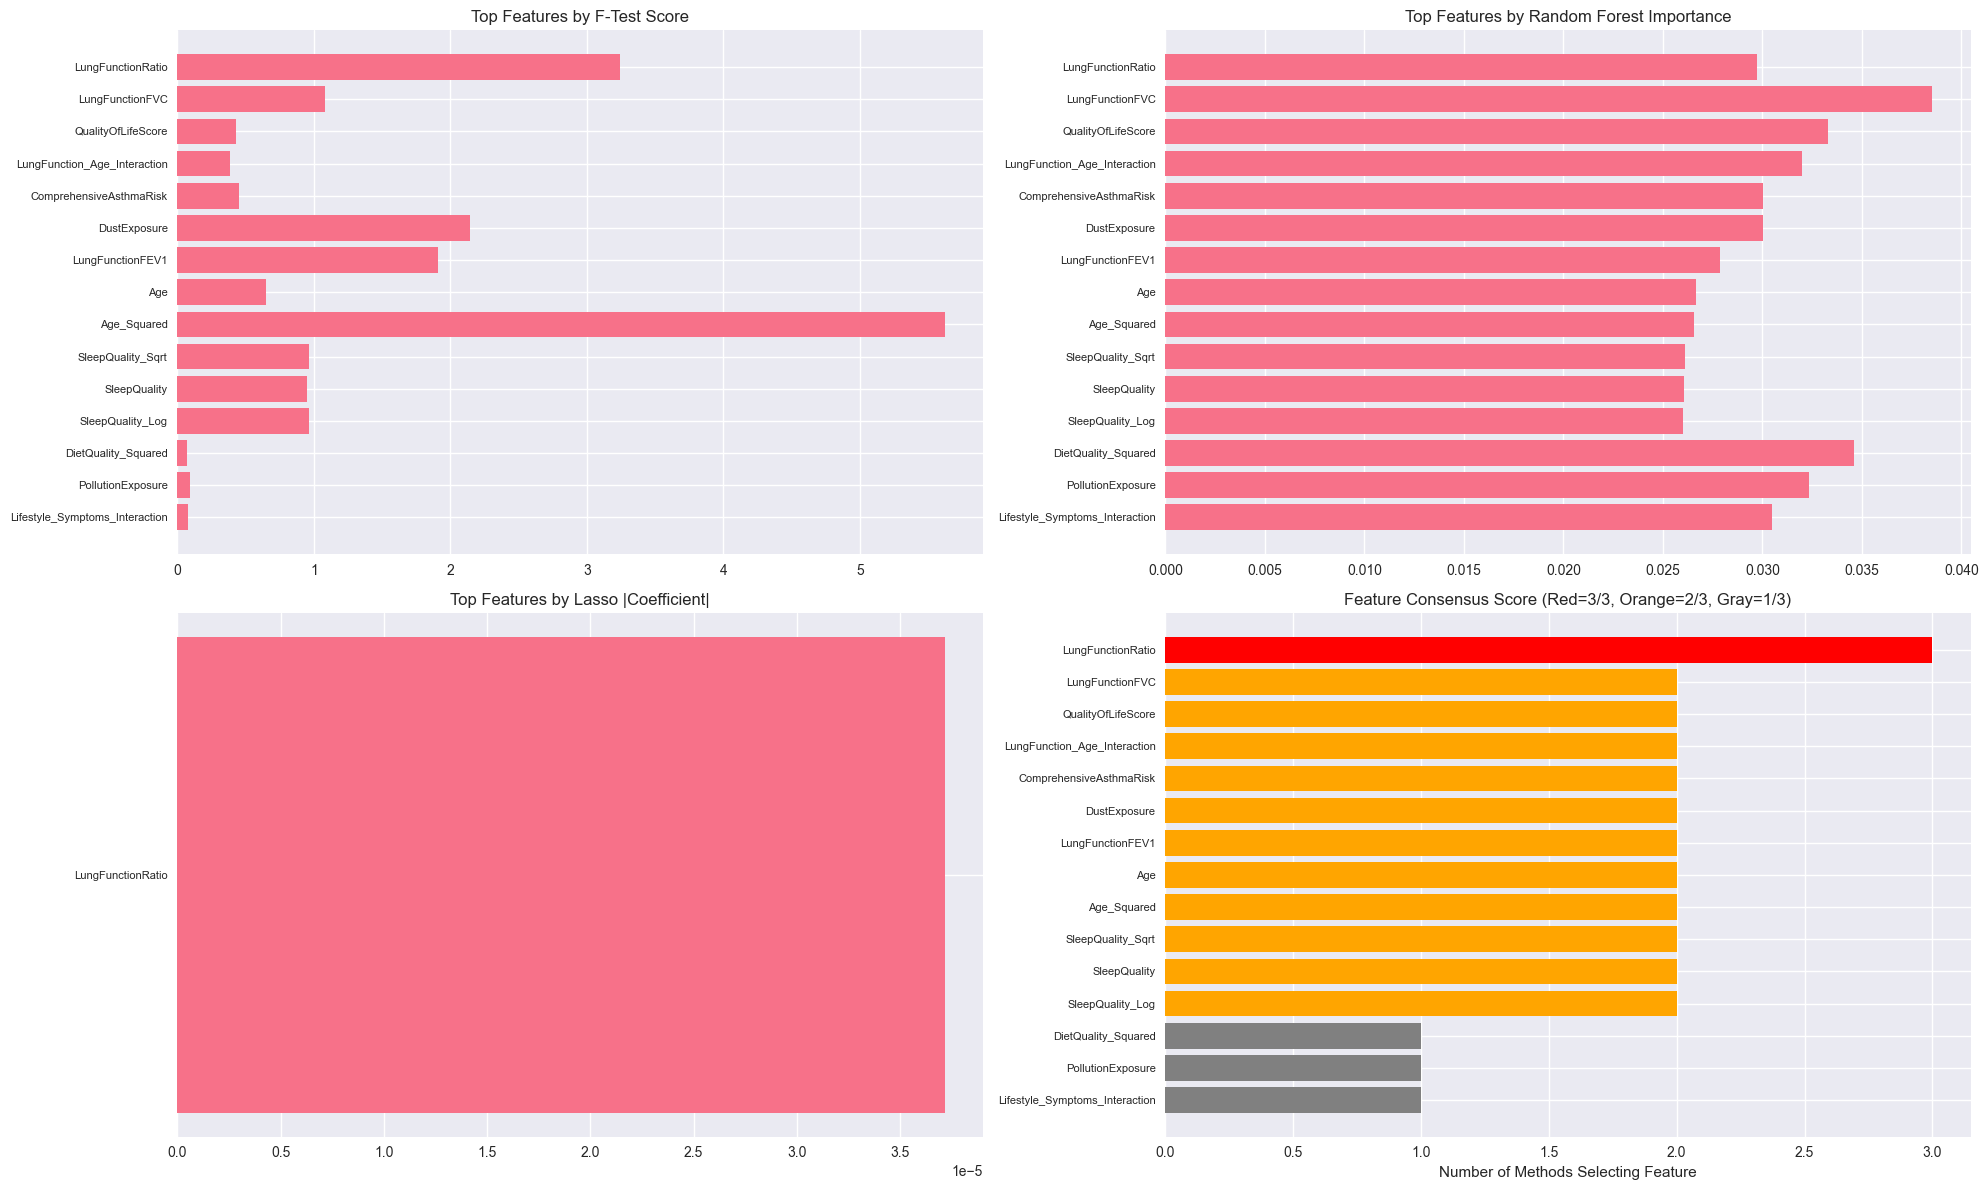

In [12]:
# =============================================================================
# 9. VISUALIZE FINAL FEATURE SET
# =============================================================================

print(f"\n" + "="*70)
print(f"📈 FINAL FEATURE VISUALIZATION")
print("="*70)

# Feature importance comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Top features by different methods
top_n = 15

# F-Test scores
top_f = consensus_features.head(top_n)
axes[0, 0].barh(range(len(top_f)), top_f['Score'])
axes[0, 0].set_yticks(range(len(top_f)))
axes[0, 0].set_yticklabels(top_f['Feature'], fontsize=8)
axes[0, 0].set_title('Top Features by F-Test Score')
axes[0, 0].invert_yaxis()

# Random Forest importance
axes[0, 1].barh(range(len(top_f)), top_f['Importance'])
axes[0, 1].set_yticks(range(len(top_f)))
axes[0, 1].set_yticklabels(top_f['Feature'], fontsize=8)
axes[0, 1].set_title('Top Features by Random Forest Importance')
axes[0, 1].invert_yaxis()

# Lasso coefficients
top_lasso = consensus_features[consensus_features['Lasso_Selected']].head(top_n)
axes[1, 0].barh(range(len(top_lasso)), abs(top_lasso['Coefficient']))
axes[1, 0].set_yticks(range(len(top_lasso)))
axes[1, 0].set_yticklabels(top_lasso['Feature'], fontsize=8)
axes[1, 0].set_title('Top Features by Lasso |Coefficient|')
axes[1, 0].invert_yaxis()

# Consensus score
consensus_viz = consensus_features.head(top_n)
colors = ['red' if x >= 3 else 'orange' if x >= 2 else 'gray' for x in consensus_viz['Consensus_Score']]
axes[1, 1].barh(range(len(consensus_viz)), consensus_viz['Consensus_Score'], color=colors)
axes[1, 1].set_yticks(range(len(consensus_viz)))
axes[1, 1].set_yticklabels(consensus_viz['Feature'], fontsize=8)
axes[1, 1].set_title('Feature Consensus Score (Red=3/3, Orange=2/3, Gray=1/3)')
axes[1, 1].set_xlabel('Number of Methods Selecting Feature')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

In [13]:
# =============================================================================
# 10. SAVE FINAL FEATURES
# =============================================================================

print(f"\n" + "="*70)
print(f"💾 SAVE FINAL FEATURE SET")
print("="*70)

# Prepare final dataset for modeling
final_dataset = pd.DataFrame(X_final)
final_dataset[TARGET_COLUMN] = y_final
final_dataset[ID_COLUMN] = df[ID_COLUMN]

# Save final feature-engineered dataset
output_dir = '../../data/processed/'
import os
os.makedirs(output_dir, exist_ok=True)

final_file = f'{output_dir}asthma_features_final.csv'
final_dataset.to_csv(final_file, index=False)
print(f"✅ Saved final dataset: {final_file}")

# Save feature engineering metadata
feature_metadata = {
    'original_features': X_original.shape[1],
    'engineered_features': X_engineered.shape[1],
    'final_features': X_final.shape[1],
    'feature_categories': {
        'original': list(X_original.columns),
        'final_selected': final_features
    },
    'selection_methods': ['F-Test', 'Random Forest', 'Lasso'],
    'selection_criteria': 'Features selected by at least 2/3 methods',
    'engineered_feature_types': [
        'Composite Medical Scores',
        'Domain-specific Features', 
        'Interaction Terms',
        'Non-linear Transformations',
        'Age Categories',
        'BMI Categories'
    ]
}

import json
with open(f'{output_dir}feature_engineering_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✅ Saved feature metadata: {output_dir}feature_engineering_metadata.json")

# Save consensus results
consensus_features.to_csv(f'{output_dir}feature_selection_consensus.csv', index=False)
print(f"✅ Saved feature selection results: {output_dir}feature_selection_consensus.csv")

print(f"\n🎉 FEATURE MANIPULATION COMPLETE!")
print(f"📊 Summary:")
print(f"   • Started with: {X_original.shape[1]} features")
print(f"   • Engineered: {X_engineered.shape[1]} features (+{X_engineered.shape[1] - X_original.shape[1]})")
print(f"   • Final selection: {X_final.shape[1]} features")
print(f"   • All features are floating-point numbers ✅")
print(f"   • Ready for machine learning modeling! 🚀")
print("="*70)


💾 SAVE FINAL FEATURE SET
✅ Saved final dataset: ../../data/processed/asthma_features_final.csv
✅ Saved feature metadata: ../../data/processed/feature_engineering_metadata.json
✅ Saved feature selection results: ../../data/processed/feature_selection_consensus.csv

🎉 FEATURE MANIPULATION COMPLETE!
📊 Summary:
   • Started with: 30 features
   • Engineered: 67 features (+37)
   • Final selection: 12 features
   • All features are floating-point numbers ✅
   • Ready for machine learning modeling! 🚀
